## Bank Marketing Data Challenge

### About Dataset

#### Description
The dataset provided is tied to the direct marketing campaigns of a banking institution. The campaigns were direct phone calls to the customer. The goal of the campaign was to get them to subscribe to a product. Often, more than one contact to the same customer was required before the goal was achieved.

##### Client info
1.	age (numeric)
2.	job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
3.	"blue-collar","self-employed","retired","technician","services") 
4.	marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
5.	education (categorical: "unknown","secondary","primary","tertiary")
6.	default: has credit in default? (binary: "yes","no")
7.  balance: average yearly balance, in euros (numeric) 
8.	housing: has a housing loan? (binary: "yes","no")
9.	loan: has personal loan? (binary: "yes","no")

##### Info on last contact of the current campaign
10.	contact: contact communication type (categorical: "unknown","telephone","cellular") 
11.	day: last contact day of the month (numeric)
12.	month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
13.	duration: last contact duration, in seconds (numeric)

##### Other data
14.	campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
15.	pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
16.	previous: number of contacts performed before this campaign and for this client (numeric)
17.	poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

##### Output
18.	y - has the client subscribed to product? (binary: "yes","no")

##### Data location: https://drive.google.com/file/d/1iN5zzbjrgT6n1eDDhaB9l3dBHRLgCsgt/view

### Instructions

This is a timed challenge, please complete the submission within an hour, submit a Jupyter notebook and a html/pdf version with your code, text, and visualizations as your output.

#####  <font color='purple'> Please look for hints in purple color through out the notebook </font>

We want to understand how you think about problems, how you apply your technical skills and creativity to solve them. Please use relevant text explanations and visualizations to communicate your assumptions, interpretation and reasoning effectively. 

We expect that candidates proficient in Python, please note the time estimate is to do the minimum required here as there is always scope to go deeper. We are not expecting deep insights or perfect solutions, given the time constraint. Pace yourself with that in mind. You are welcome to spend additional hour if you are interested in going deeper to showcase your skills.

### Import Modules

In [1]:
### Some of the standard modules that you might want to import
### Please import other packages that you would like to

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import xgboost

### Read in data

In [2]:
# Read in data, show data types and data head
df = pd.read_csv('bank-full.csv', delimiter=';',index_col=None)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.drop_duplicates()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1. Evaluate the performance of this campaign and describe the relationship between key factors and performance. The minimum expectation here is some simple analysis and visualizations followed by some discussion as needed.

In [5]:
### compute campaign success rate:
success=df['y'].value_counts(normalize=True)
print('Success Rate for this campaign is {:.2f}%'.format(( success['yes'])*100))

Success Rate for this campaign is 11.70%


#### Primary measures of success of campaign
The first measure of the campaign success is the number or proportion of successful subscriptions. The campaign had a 11.7% subscription rate.

###  Potential secondary success metrics for the campaign 

A cost function could be defined to calculate the cost of the campaign for that particular customer together with the revenue the campaing produced (if it did produce any).

For example if the campaign required 3 contacts to the customer that could mean 3 x 15mins dedication from an agent, we could estimate that cost to 90 USD and in the particular case the campaign was successful we could estimate the bank earned 1000 USD
In this case there would be a cost of 90 USD with a revenue of 1000 USD producing a total campaign cost of -910 USD.

Calculating such a KPI could be a secondary success metric closer to business.

To calculate the global success of the campaign such KPI could be summed up for all campaign participants which would result in the calculated cost or revenue of the campaign.

### Explore data to understand distributions of both continuous and categorical fields and identify the biggest factor driving success

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
# run describe() for non-conversion cases
df[df["y"]=='no'].describe()

,age,balance,day,duration,campaign,pdays,previous
count,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000
mean,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
std,10.172662,2974.195473,8.294728,207.383237,3.212767,96.757135,2.256771
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,58.000000,8.000000,95.000000,1.000000,-1.000000,0.000000
50%,39.000000,417.000000,16.000000,164.000000,2.000000,-1.000000,0.000000
75%,48.000000,1345.000000,21.000000,279.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
# run describe() for conversion cases
df[df["y"]=='yes'].describe()

,age,balance,day,duration,campaign,pdays,previous
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354
std,13.497781,3501.104777,8.501875,392.525262,1.921826,118.822266,2.553272
min,18.000000,-3058.000000,1.000000,8.000000,1.000000,-1.000000,0.000000
25%,31.000000,210.000000,8.000000,244.000000,1.000000,-1.000000,0.000000
50%,38.000000,733.000000,15.000000,426.000000,2.000000,-1.000000,0.000000
75%,50.000000,2159.000000,22.000000,725.000000,3.000000,98.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,32.000000,854.000000,58.000000


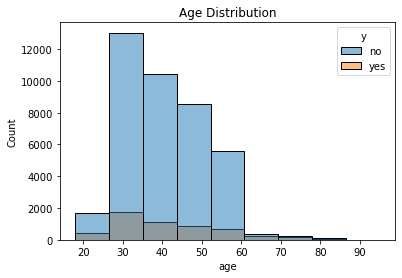

In [9]:
#### insight on job category vs conversion 
sns.histplot(data = df, x = 'age', hue = 'y',bins = 9)
plt.title('Age Distribution')
plt.show()

There isn't a clear distribution difference of age by subscribed vs unsubscribed. So I will break the age into a few buckets and look at the subscription rate of each bucket.

<AxesSubplot:xlabel='age_bucket', ylabel='subscription_rate'>

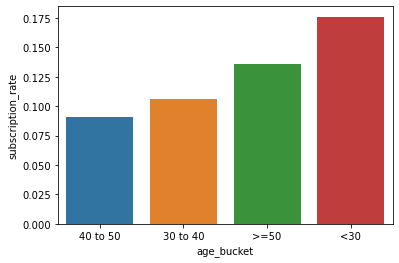

In [10]:
# break the age into different buckets: <30; 30-50; >50
df.loc[df['age']<30,'age_bucket'] = '<30'
df.loc[(df['age']>=30) & (df['age'] <40) ,'age_bucket'] = '30 to 40'
df.loc[(df['age']>=40) & (df['age'] <50) ,'age_bucket'] = '40 to 50'
df.loc[(df['age']>=50) ,'age_bucket'] = '>=50'

# convert the values of y to 0 or 1
df['y_int'] = np.where(df.y == 'yes',1,0)

stats = pd.pivot_table(data=df, index = 'age_bucket', values = 'y_int', aggfunc=['count','mean']).reset_index()
stats.columns = ['age_bucket','count','subscription_rate']
sns.barplot(data=stats.sort_values(by='subscription_rate'),x='age_bucket',y='subscription_rate')

The subscription rate of the group with age between 30 to 50 is much lower than that of people under 30 years old.

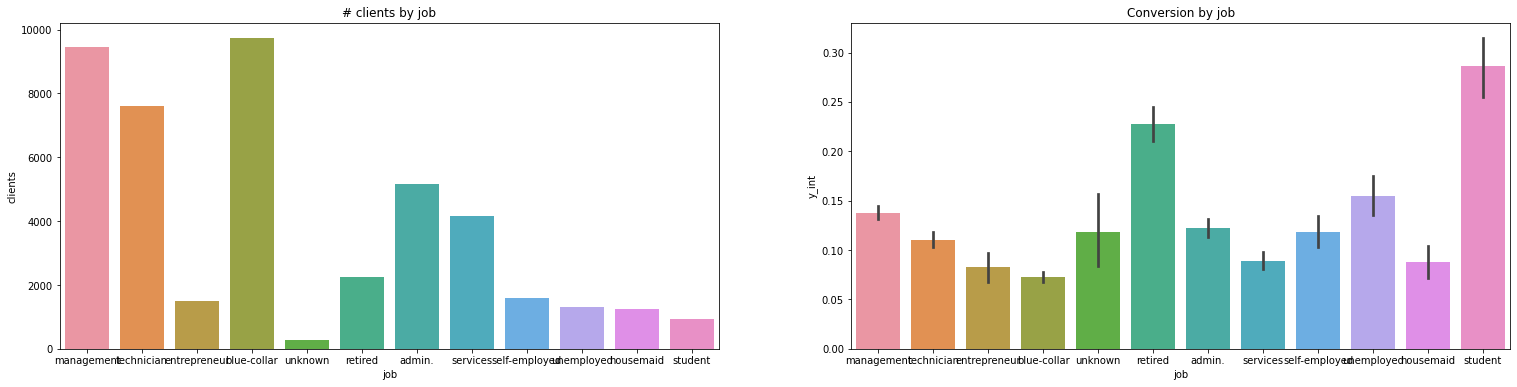

In [10]:
#### insight on job categgory vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='job', data=df, ax=ax[0])
sns.barplot(x = 'job', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by job', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by job', fontsize=12)
plt.show()

Students and retired people have the most conversion; while most of the clients being reached out are blue collars, management and technicians

###  Perform additional Exploratory analysis

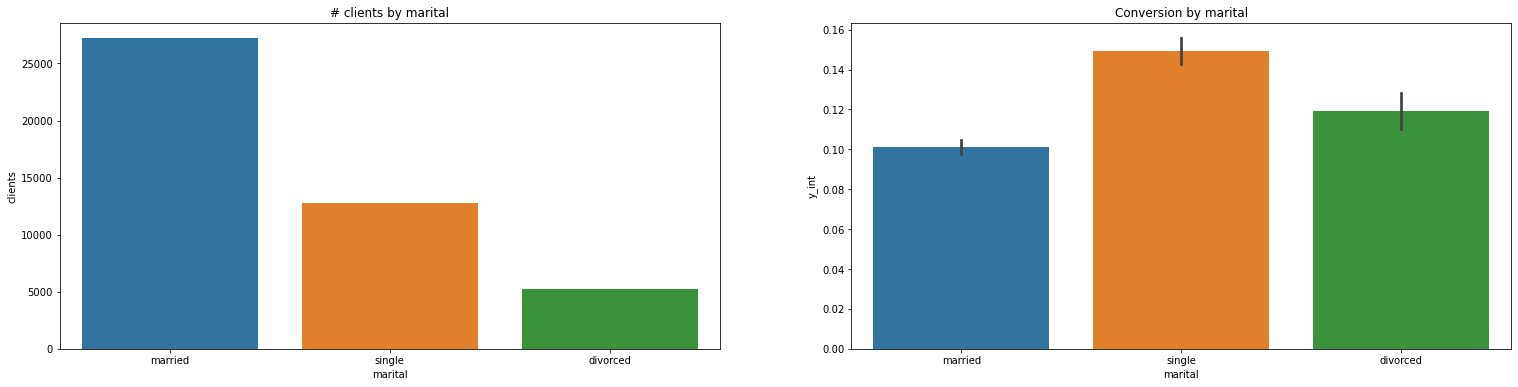

In [11]:
#### insight on marital vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='marital', data=df, ax=ax[0])
sns.barplot(x = 'marital', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by marital', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by marital', fontsize=12)
plt.show()

Single customers have the most conversion while married were the most reached out

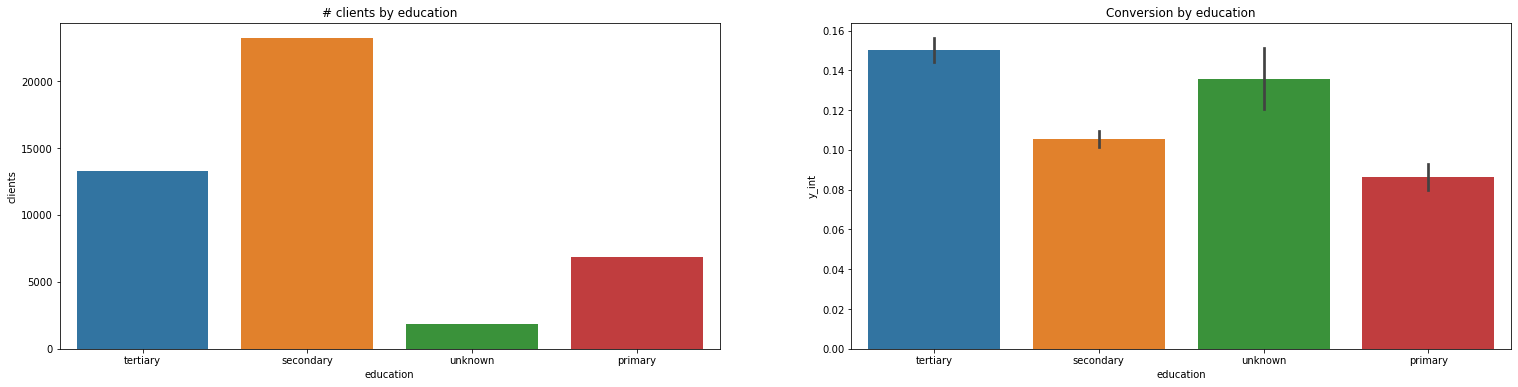

In [12]:
#### insight on education vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='education', data=df, ax=ax[0])
sns.barplot(x = 'education', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by education', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by education', fontsize=12)
plt.show()

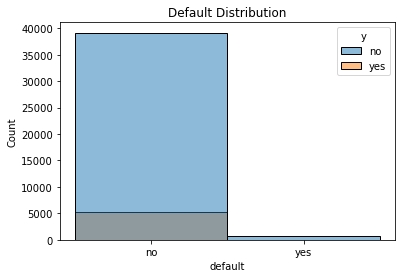

In [13]:
#### insight on default vs conversion 
sns.histplot(data = df, x = 'default', hue = 'y',bins = 2)
plt.title('Default Distribution')
plt.show()

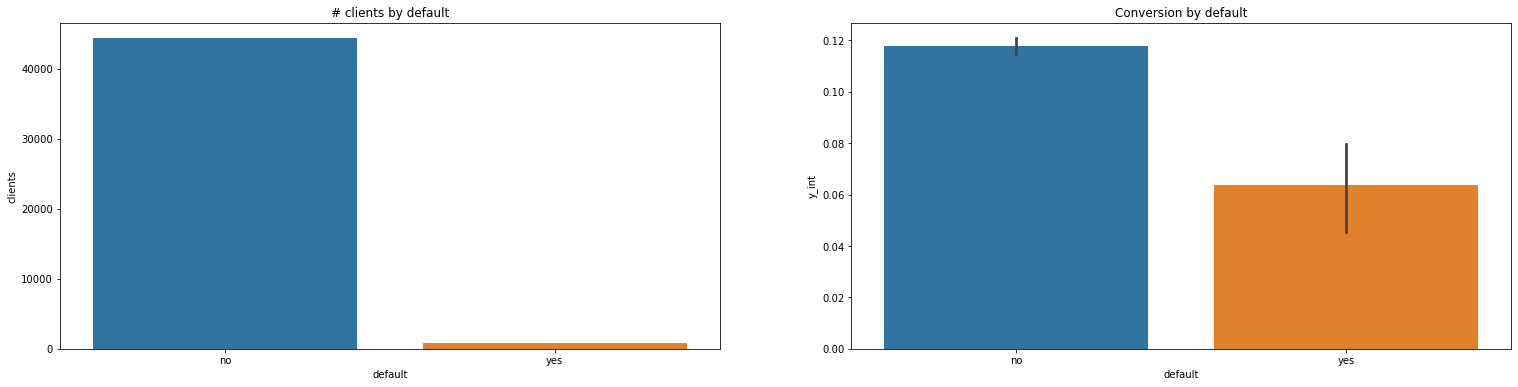

In [14]:
#### insight on education vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='default', data=df, ax=ax[0])
sns.barplot(x = 'default', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by default', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by default', fontsize=12)
plt.show()

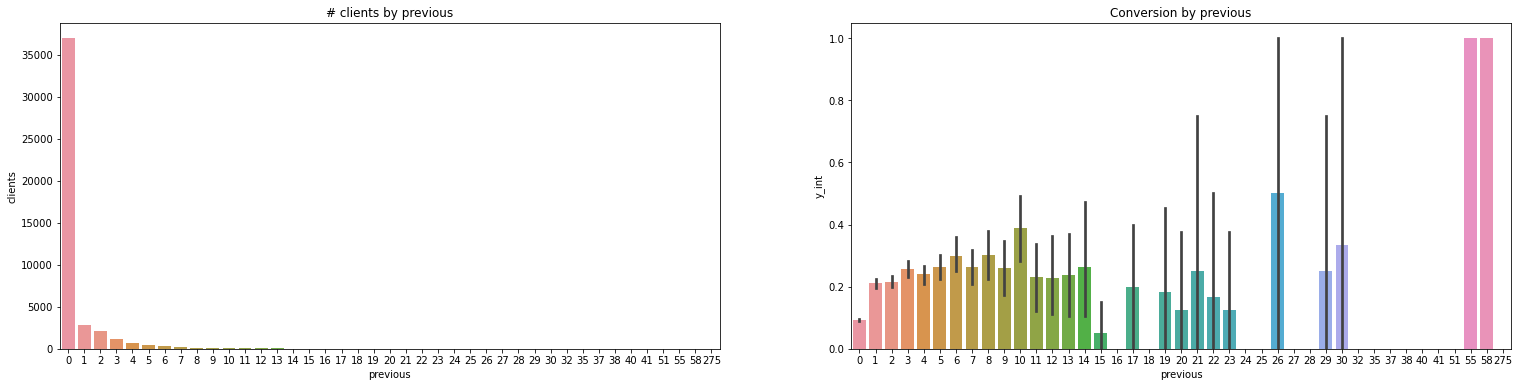

In [15]:
#### insight on education vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='previous', data=df, ax=ax[0])
sns.barplot(x = 'previous', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by previous', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by previous', fontsize=12)
plt.show()

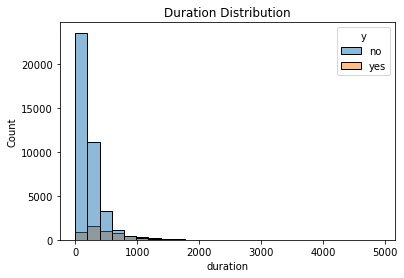

In [22]:
#### insight on last call duration vs conversion 
sns.histplot(data = df, x = 'duration', hue = 'y',bins = 25)
plt.title('Duration Distribution')
plt.show()

It seems the last call duration has a big impact to conversion, the longest the call the most conversion. This should be an important feature.

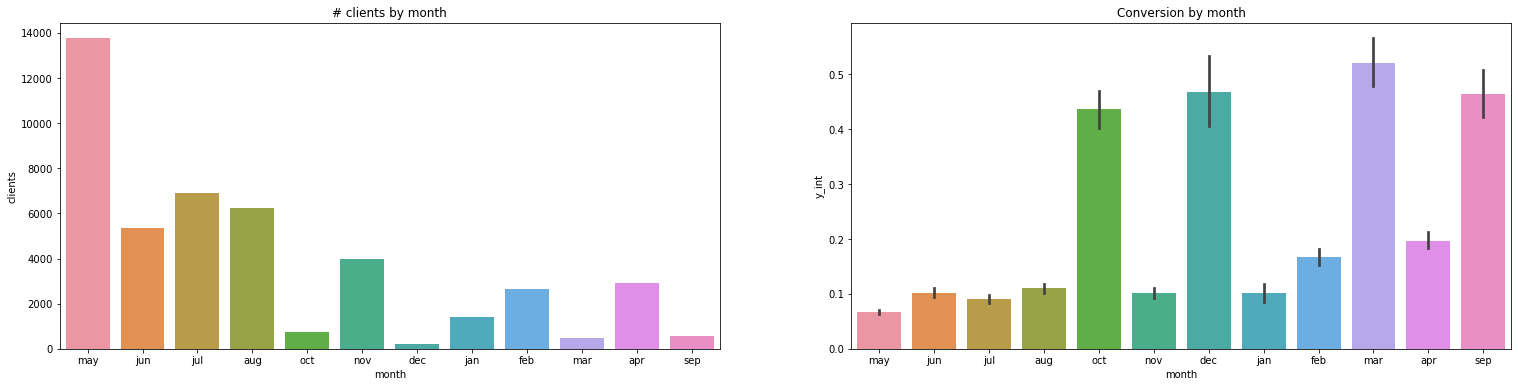

In [24]:
#### insight on month vs conversion 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 6))
sns.countplot(x='month', data=df, ax=ax[0])
sns.barplot(x = 'month', y = 'y_int', data = df, ax = ax[1])
ax[0].set_title('# clients by month', fontsize=12)
ax[0].set_ylabel('clients')
ax[1].set_title('Conversion by month', fontsize=12)
plt.show()

Also it seems data distribution across months is far from being event, which accidentally brings more conversion to months where fewer calls were made. This feature could be deterministic and found important by models, however from my understanding it should not be useful in reality. We might want to consider removing it.

Instead a "time since last contact" feature could be calculated and more useful.

### Build a baseline clissifcation Model

In [13]:
# create binary y variable
df_model = df.copy()
df_model['y'] = [1 if y == 'yes' else 0 for y in df['y']]

# baseline model to benchmark  performance and to check its feature importance

features = ['age', 'balance', 'campaign', 'contact', 'day', 'default', 'duration', 'education',
            'housing', 'job', 'loan', 'marital', 'month', 'pdays', 'poutcome', 'previous']

target = 'y'

# encode categorical variables for xgboost preprocessing
lbl = preprocessing.LabelEncoder()
for col in df_model.columns:
    if df_model.dtypes[col] == 'object':
        df_model[f'{col}_orig'] = df_model[col]
        df_model[col] = lbl.fit_transform(df_model[col])


X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### Run Model

In [16]:
# run XGBOOST
model = xgboost.XGBClassifier(eval_metric=['auc','aucpr'], use_label_encoder=False)
model.fit(X_train, 
          y_train, 
          early_stopping_rounds=10, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False)
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=['auc', 'aucpr'], gamma=0, gpu_id=-1,
       grow_policy='depthwise', importance_type=None,
       interaction_constraints='', learning_rate=0.300000012, max_bin=256,
       max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', predictor='auto', random_state=0,
       reg_alpha=0, reg_lambda=1, sampling_method='uniform',
       scale_pos_weight=1, subsample=1, tree_method='exact',
       use_label_encoder=False, validate_parameters=1, verbosity=None)